### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Mon Sep 30 15:52:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [1]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLO11 via Ultralytics

In [2]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.143 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.5/112.6 GB disk)


**NOTE:** When training YOLO11, make sure your data is located in `{HOME}/datasets`. If you'd like to change the default location of the data you want to use for fine-tuning, you can do so through Ultralytics' `settings.json`. When downloading data from [Roboflow Universe](https://universe.roboflow.com/), use the YOLOv8 format.

In [3]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="OBEE4ABTRkFaMw51pNpg")
project = rf.workspace("capstone-v0wnd").project("papule-6mjej")
version = project.version(2)
dataset = version.download("yolov11")


mkdir: cannot create directory ‘/content/datasets’: File exists
/content/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to papule-2 in yolov11:: 100%|██████████| 268/268 [00:00<00:00, 8663.31it/s]


**NOTE:** Make sure to run commands below to make dataset work with YOLO11 training.

In [4]:
!sed -i '$d' {dataset.location}/data.yaml   # Delete the last line
!sed -i '$d' {dataset.location}/data.yaml   # Delete the second-to-last line
!sed -i '$d' {dataset.location}/data.yaml   # Delete the third-to-last line

!echo 'test: ../test/images' >> {dataset.location}/data.yaml
!echo 'train: ../train/images' >> {dataset.location}/data.yaml
!echo 'val: ../valid/images' >> {dataset.location}/data.yaml

## Custom Training

In [5]:
%cd {HOME}

!yolo task=detect mode=train model=yolo11s.pt data={dataset.location}/data.yaml epochs=10 imgsz=640 plots=True

/content
100% 18.4M/18.4M [00:00<00:00, 446MB/s]
Ultralytics 8.3.143 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/datasets/papule-2/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patienc

**NOTE:** The results of the completed training are saved in `{HOME}/runs/detect/train/`. Let's examine them.

In [6]:
!ls {HOME}/runs/detect/train/

args.yaml			 P_curve.png	   train_batch1.jpg
confusion_matrix_normalized.png  PR_curve.png	   train_batch2.jpg
confusion_matrix.png		 R_curve.png	   val_batch0_labels.jpg
F1_curve.png			 results.csv	   val_batch0_pred.jpg
labels_correlogram.jpg		 results.png	   weights
labels.jpg			 train_batch0.jpg


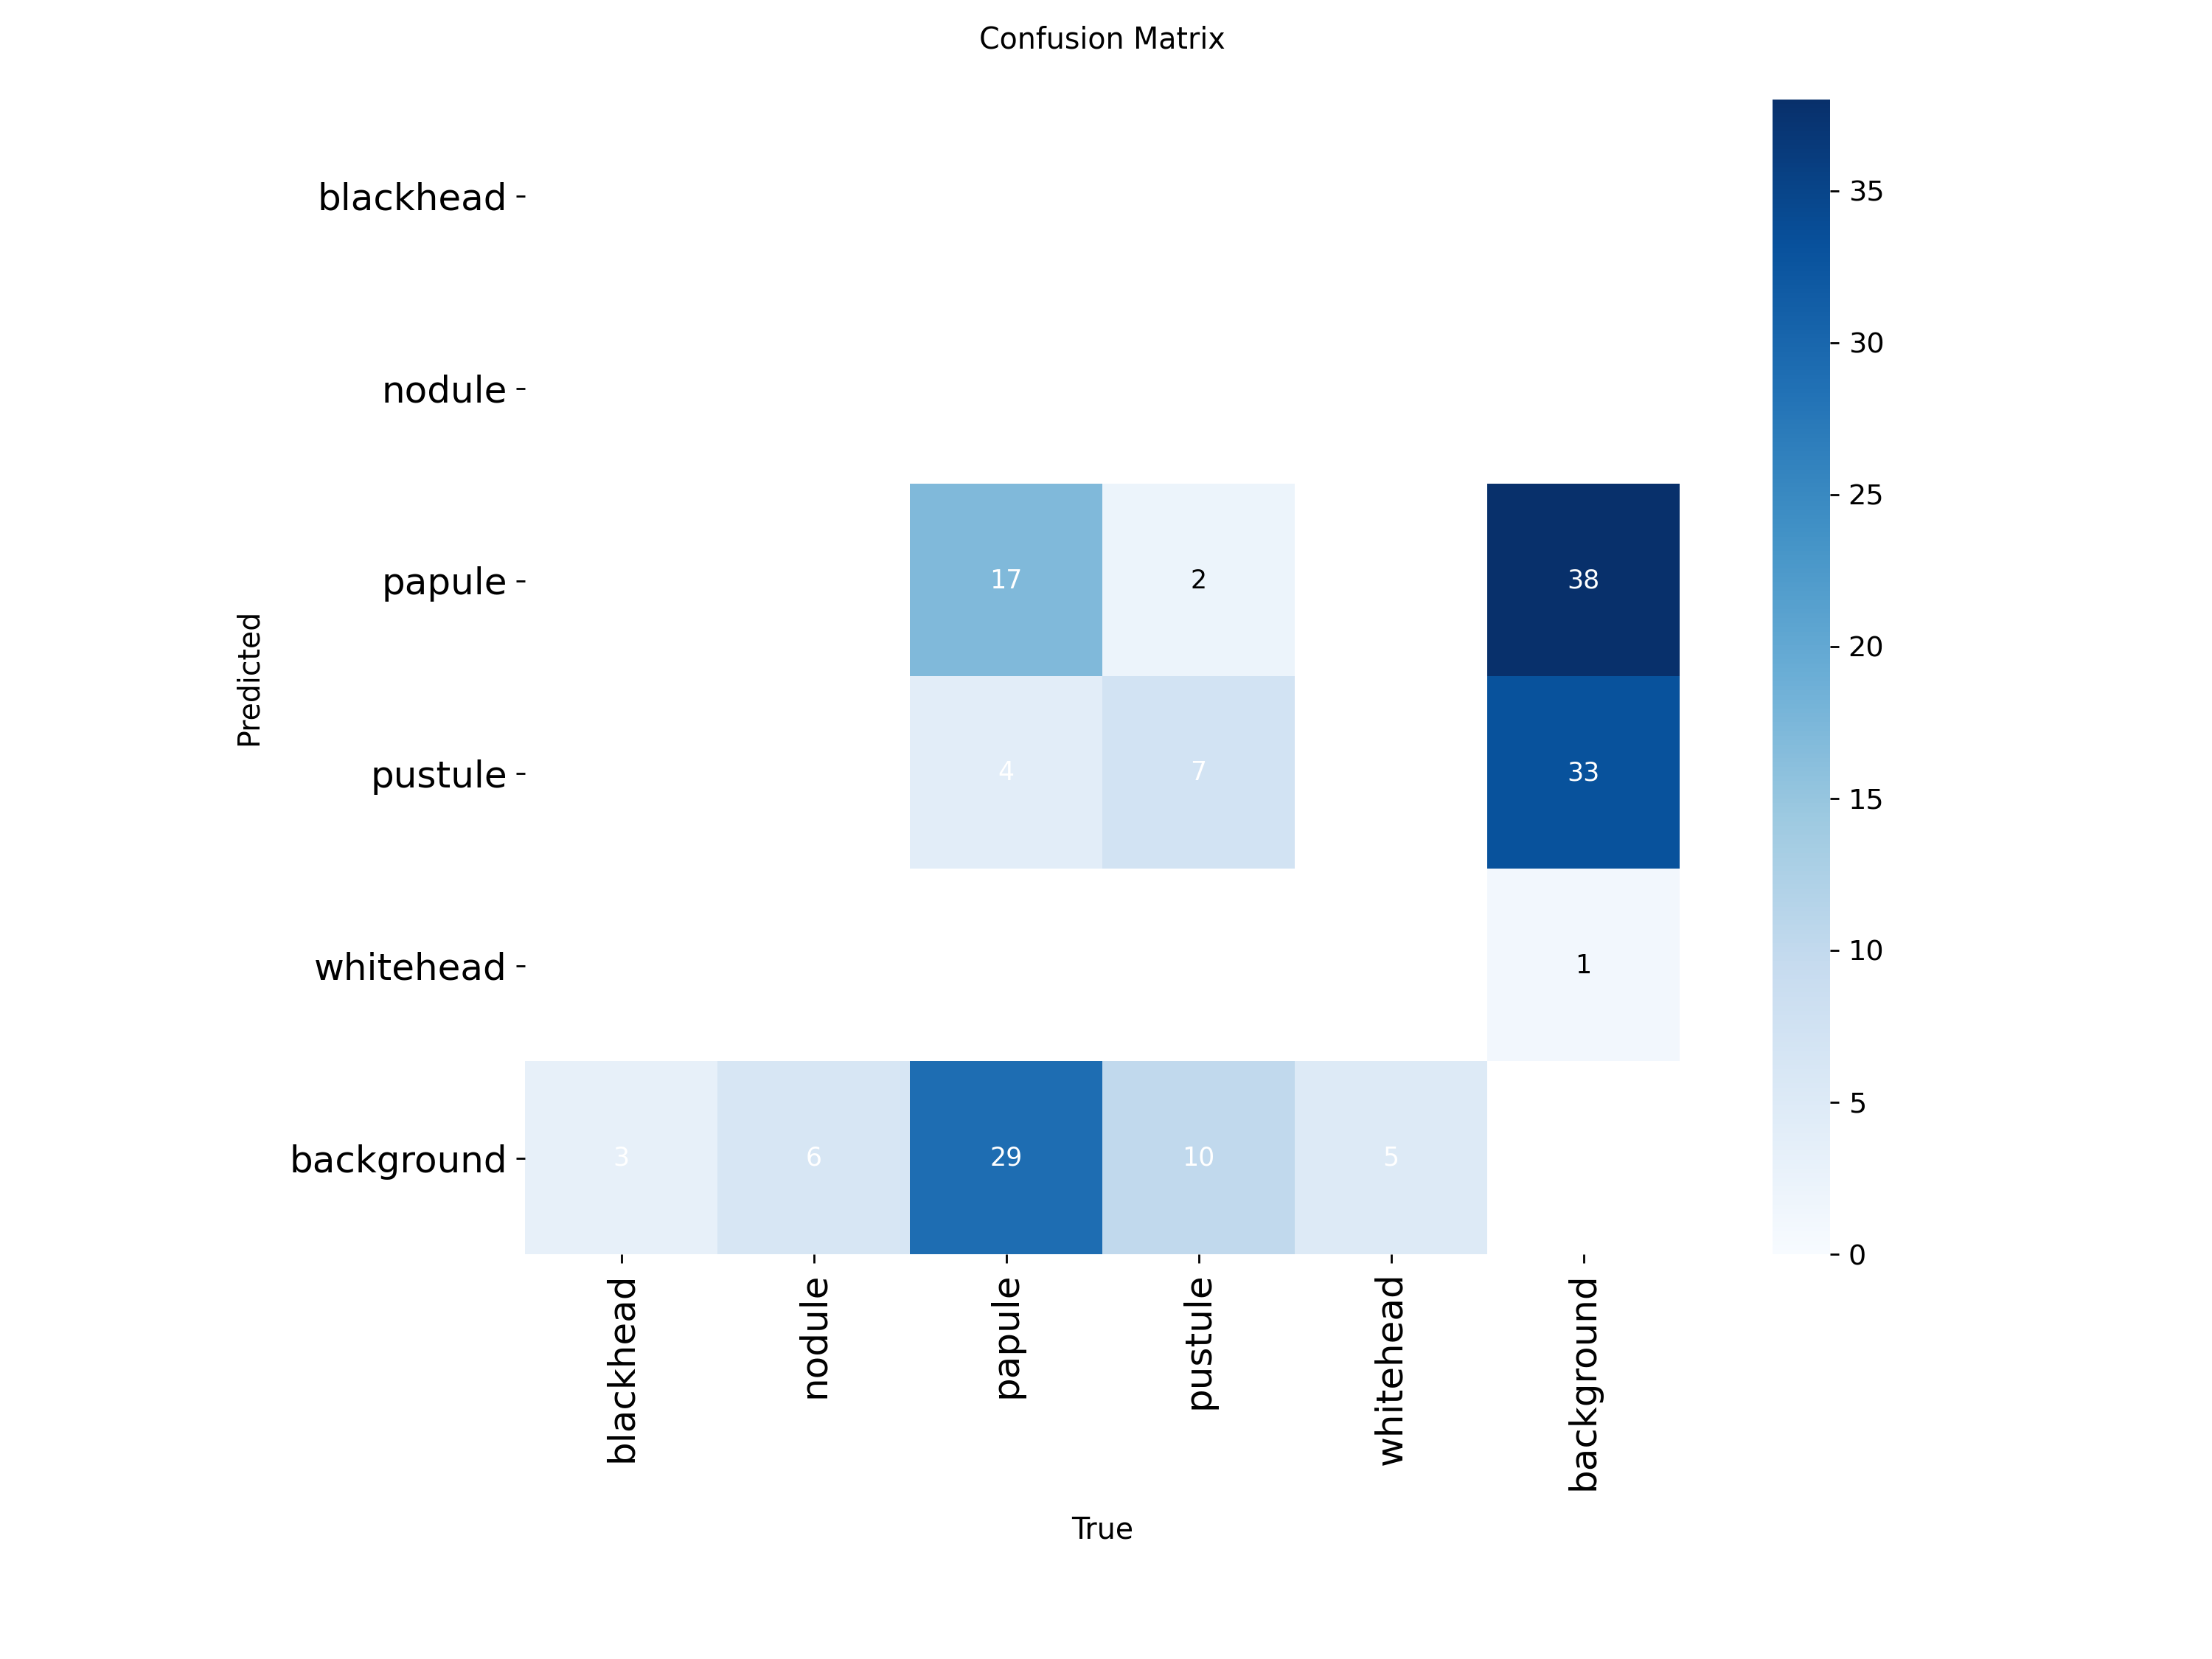

In [7]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

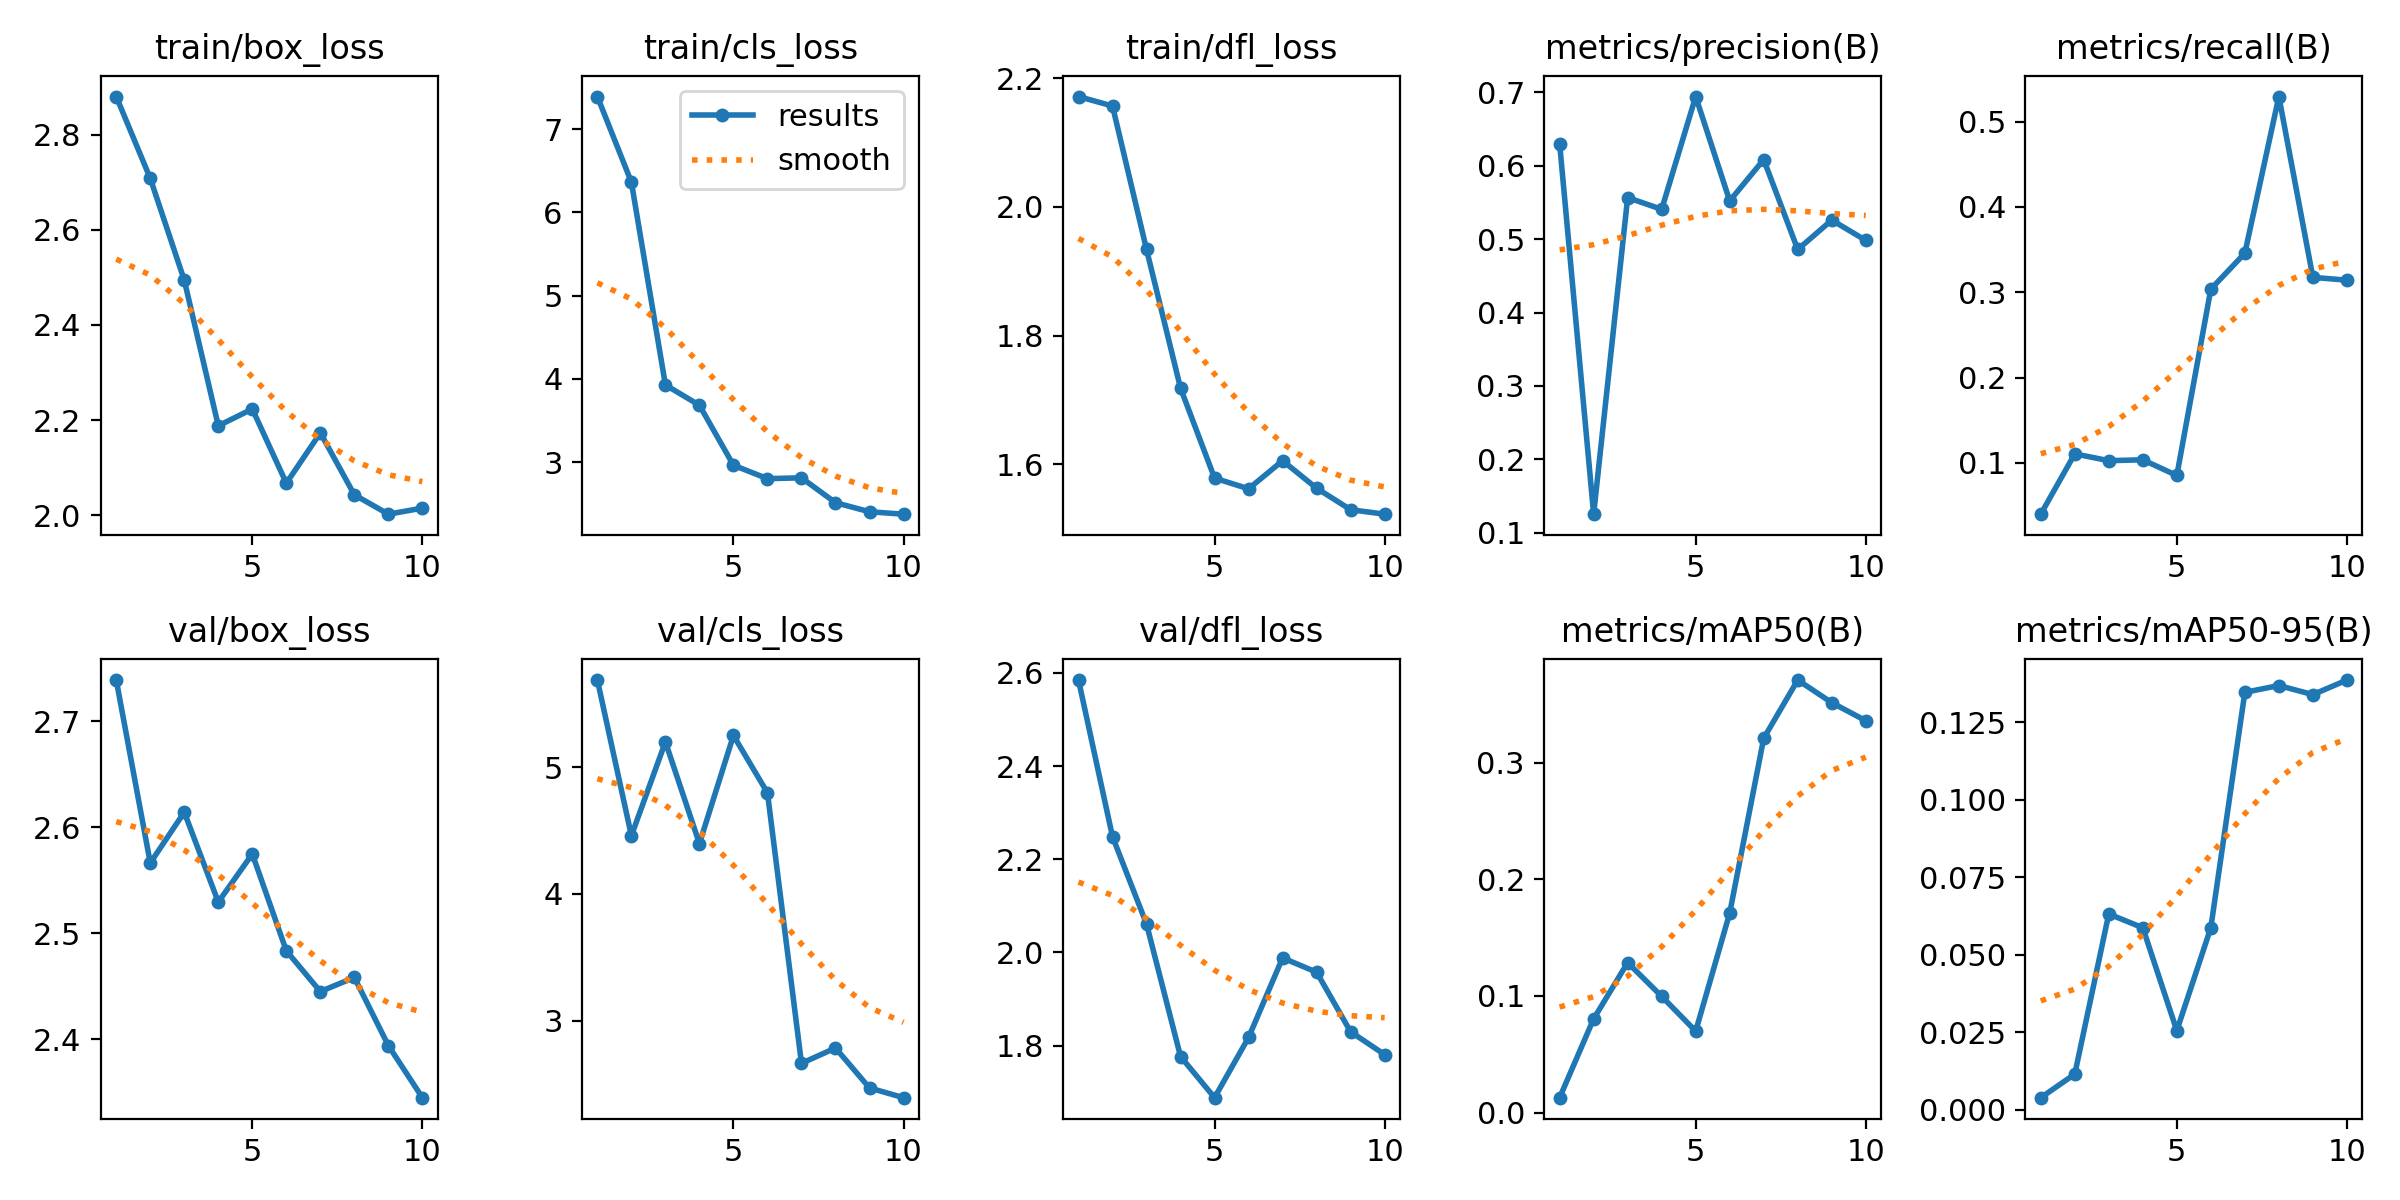

In [8]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/results.png', width=600)

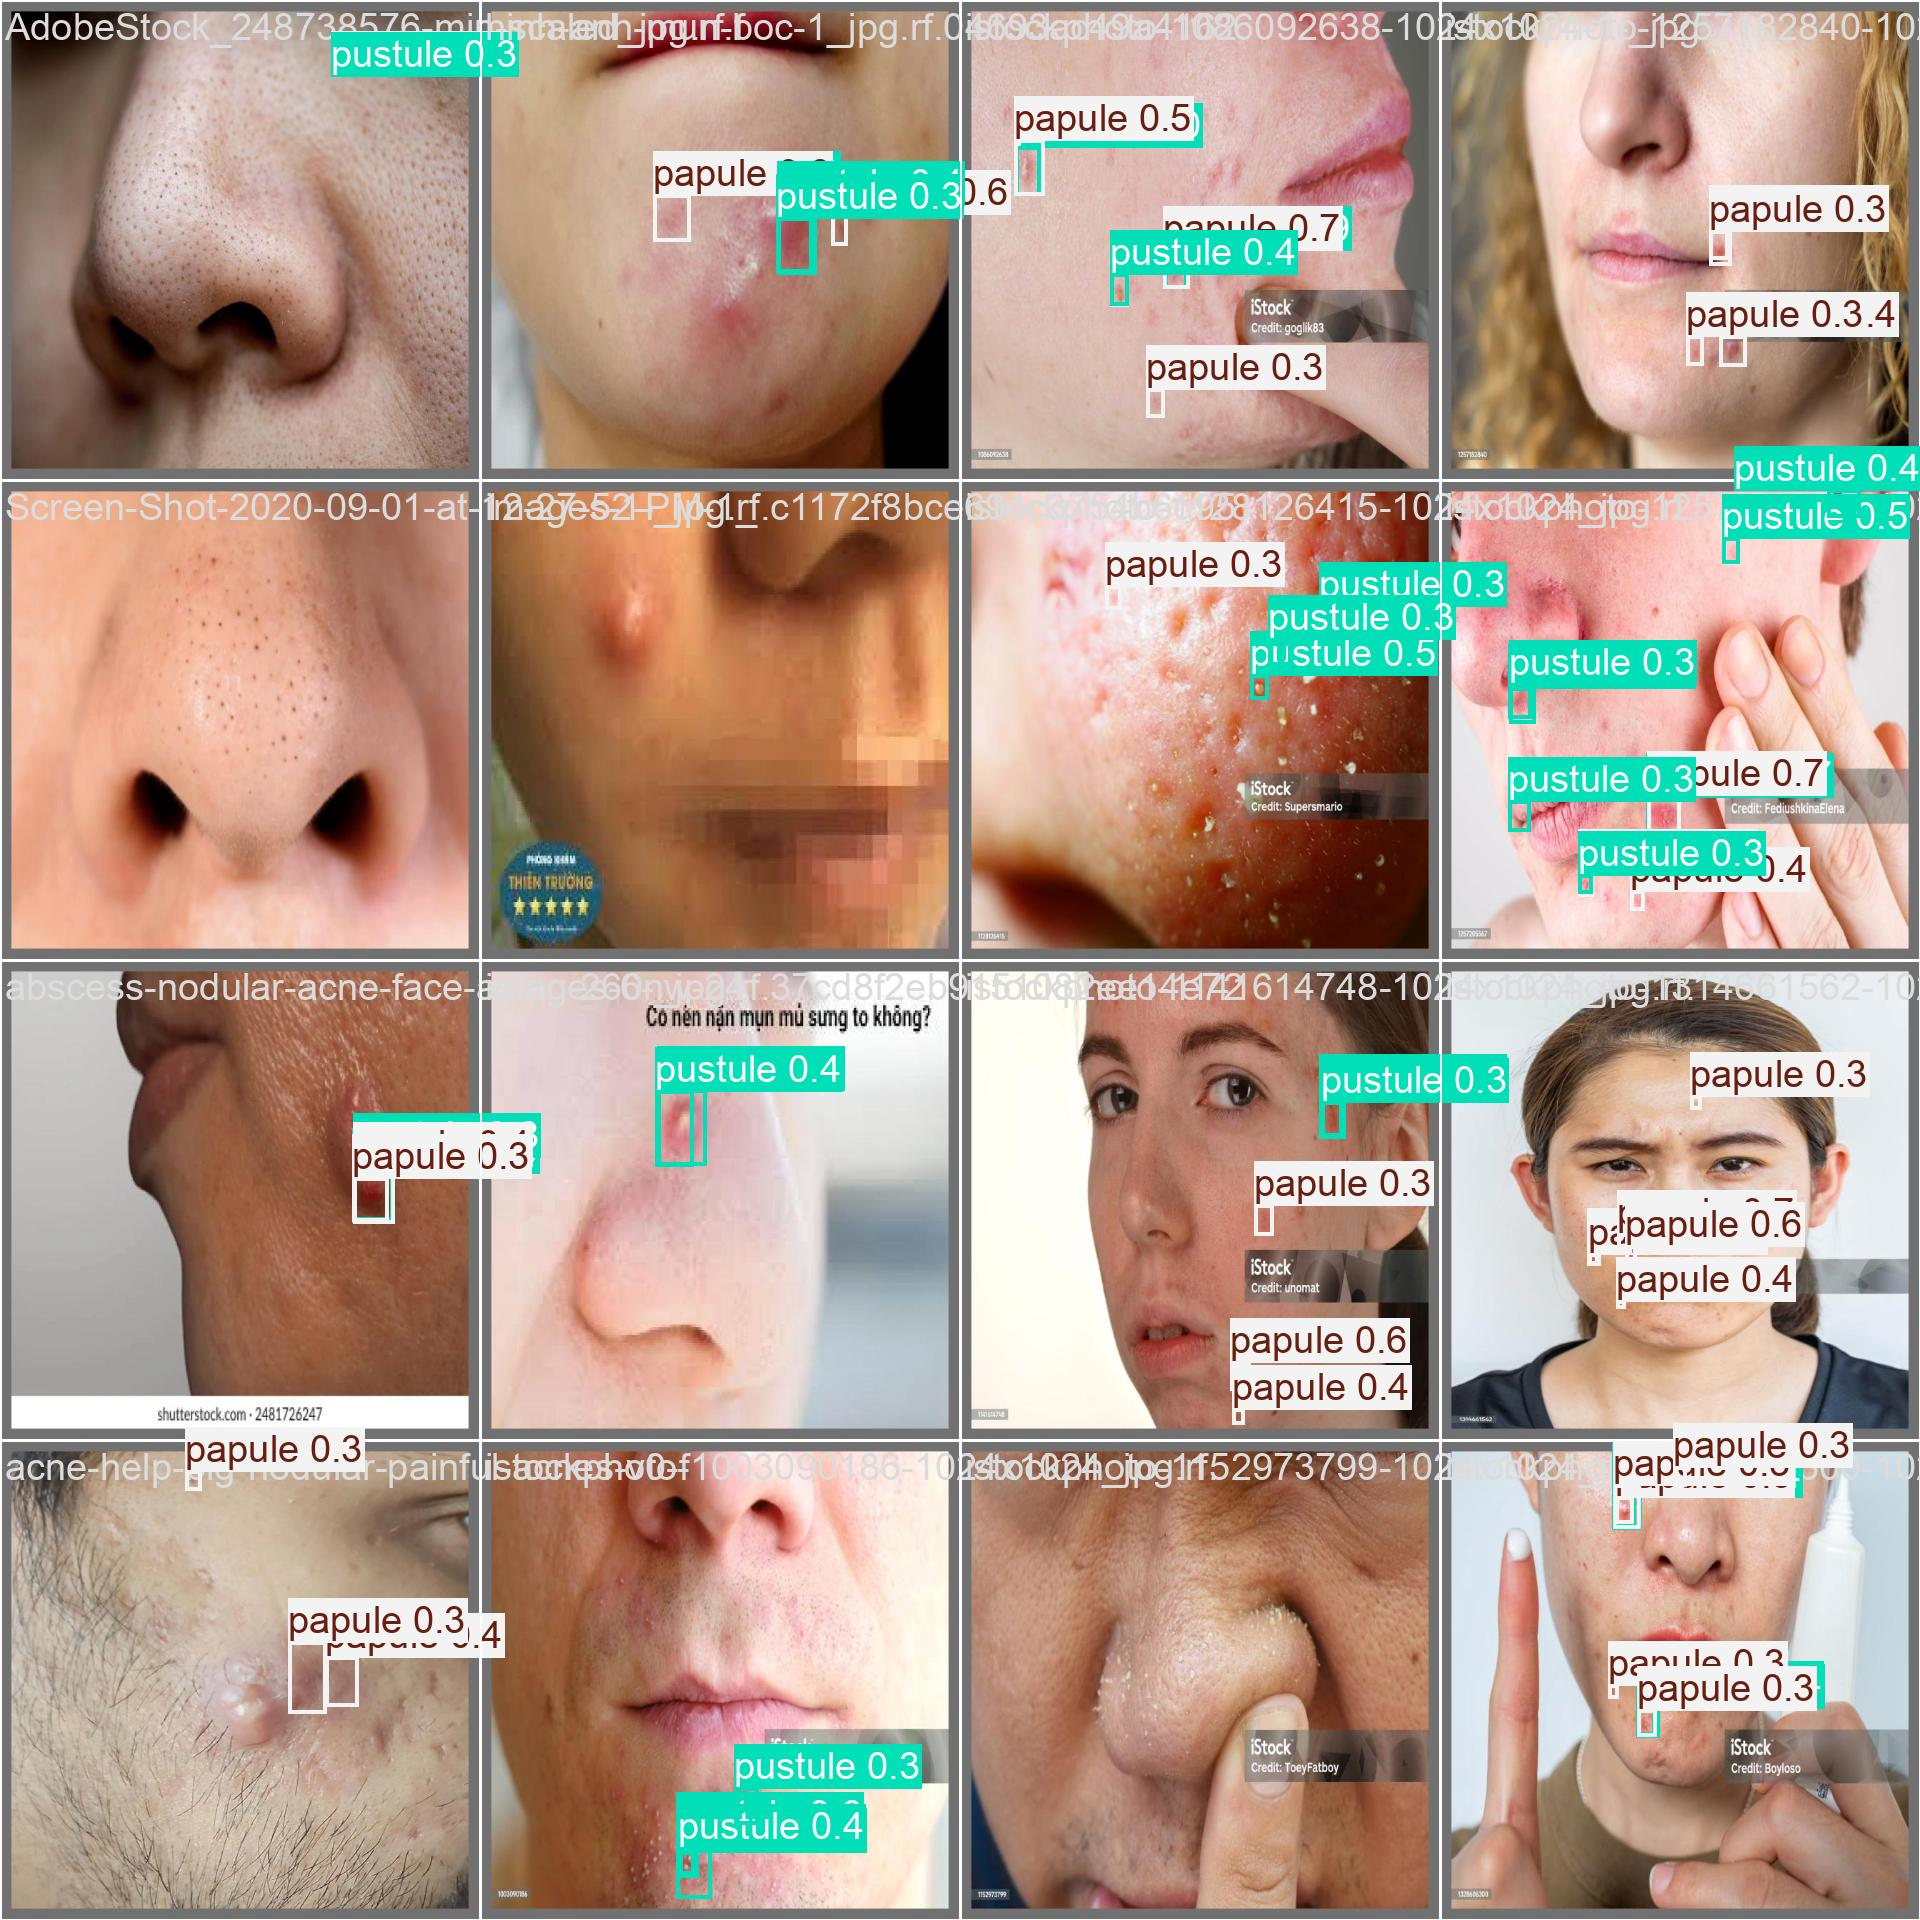

In [9]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## Validate fine-tuned model

In [10]:
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.143 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,414,735 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1119.4±245.5 MB/s, size: 32.5 KB)
val: Scanning /content/datasets/papule-2/valid/labels.cache... 25 images, 0 backgrounds, 0 corrupt: 100% 25/25 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 2/2 [00:01<00:00,  1.71it/s]
                   all         25         83      0.486       0.53      0.371      0.133
             blackhead          3          3      0.984      0.667      0.669      0.307
                nodule          6          6          1      0.429      0.571      0.165
                papule         11         50      0.218       0.52      0.314      0.082
               pustule          8         19      0.136      0.632      0.166     0.0446
             whitehead          4          5     0.0

## Inference with custom model

In [11]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Ultralytics 8.3.143 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,414,735 parameters, 0 gradients, 21.3 GFLOPs

image 1/13 /content/datasets/papule-2/test/images/blackhead-treatment-before-after-collage-600nw-2418681335_jpg.rf.3802fa227b6c7c5f55b2a7d0575d01d0.jpg: 640x640 (no detections), 15.8ms
image 2/13 /content/datasets/papule-2/test/images/images-2-_jpg.rf.3d6a1c92368e5f3e011d3c1b8b9824eb.jpg: 640x640 (no detections), 15.6ms
image 3/13 /content/datasets/papule-2/test/images/images-3-_jpg.rf.f9af71cc3a602b85662483077048fc34.jpg: 640x640 (no detections), 15.6ms
image 4/13 /content/datasets/papule-2/test/images/istockphoto-1080509832-1024x1024-1-_jpg.rf.98570d58c39a42417b515083b68fcc17.jpg: 640x640 (no detections), 15.6ms
image 5/13 /content/datasets/papule-2/test/images/istockphoto-1167911834-2048x2048_jpg.rf.a4396378a7da7292afff9e72f88cfb5b.jpg: 640x640 5 papules, 2 pustules, 15.6ms
image 6/13 /content/datasets/papule-2/test/i

**NOTE:** Let's take a look at few results.

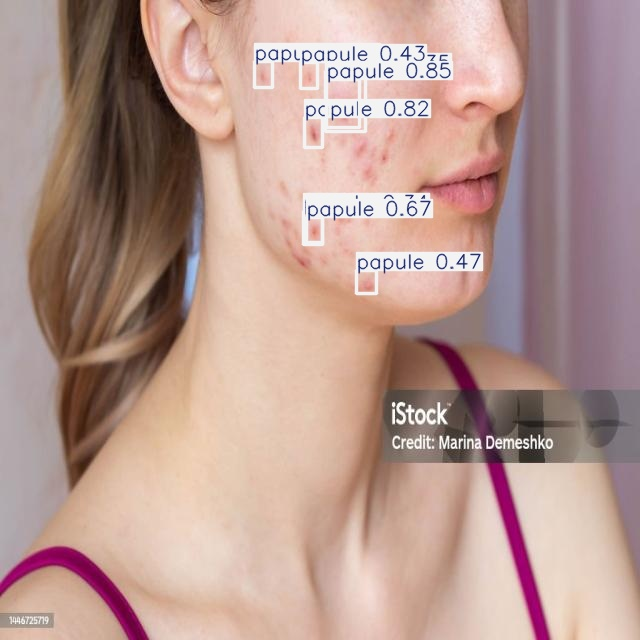

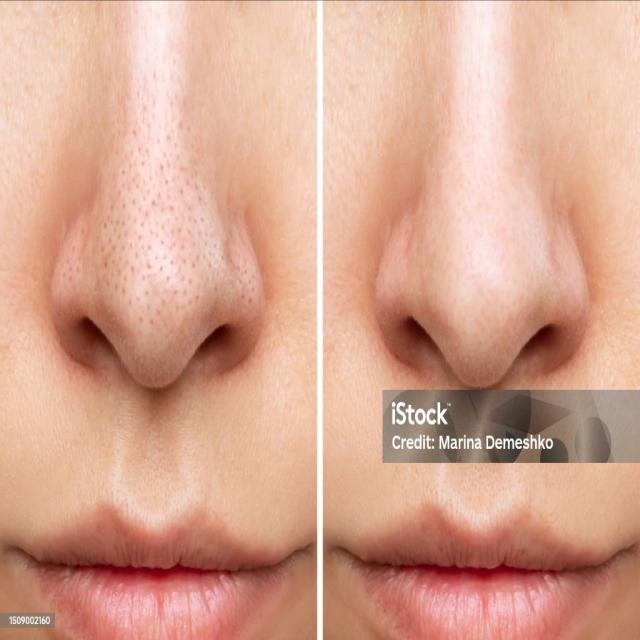

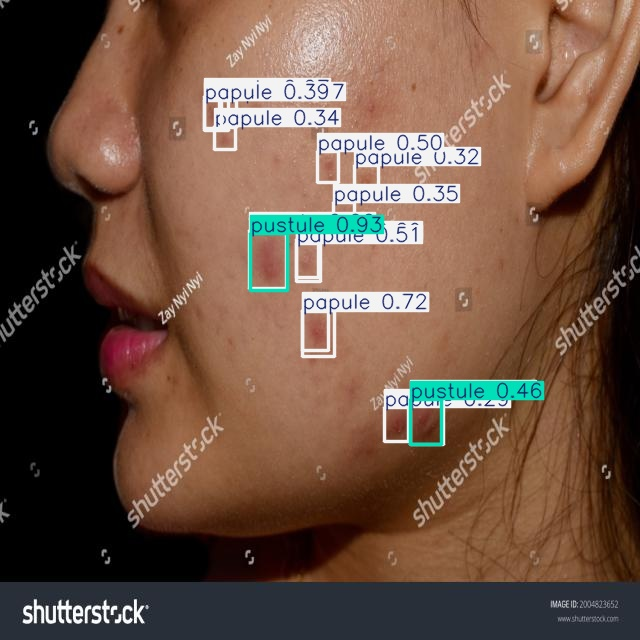

In [12]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob('/content/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")

In [15]:
import cv2
import torch
import os

# Path ke model
model_path = os.path.expanduser('{HOME}/runs/detect/train/weights/best.pt')

# Load model YOLO
model = torch.hub.load('ultralytics/yolov5', 'custom', path=model_path)


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-5-24 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)



Exception: [Errno 2] No such file or directory: '{HOME}/runs/detect/train/weights/best.pt'. Cache may be out of date, try `force_reload=True` or see https://docs.ultralytics.com/yolov5/tutorials/pytorch_hub_model_loading for help.